##

Name : Sobhan Asasi

Std Num : 400206392

# Requirements

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time


# Dataset

In [17]:
class DataSet(Dataset):

    def __init__(self, add):
        super(DataSet, self).__init__()
        self.data = pd.read_csv(add)
        self.data = self.data.to_numpy()
    def __getitem__(self, index):
        inputs = torch.tensor(self.data[index, 1:] / 255.0, dtype=torch.float32)
        targets = torch.tensor(int(self.data[index, 0]), dtype=torch.int64)
        return inputs, targets

    def __len__(self):
        return len(self.data)

dataset_train = DataSet(add='./Data/Q3_train.csv')
dataset_test = DataSet(add='./Data/Q3_test.csv')

In [18]:
alphabet = list(map(chr, range(97, 122)))
print(alphabet)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


# PLot some Random Examples

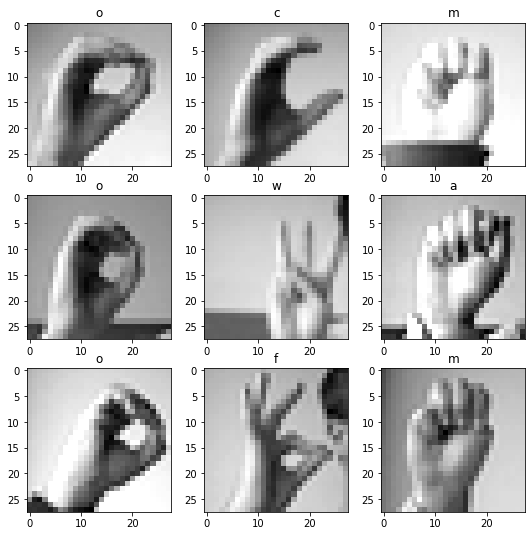

In [19]:
rnd_samples = random.sample(list(range(len(dataset_train))), 9)
plt.figure(figsize=(9,9))
for idx, samp in enumerate(rnd_samples):
    example, label = dataset_train[samp]
    plt.subplot(int(f'33{idx+1}'))
    plt.imshow(example.reshape((28,28)), cmap='gray')
    plt.title(alphabet[label.item()])


# Split train dataset into train and validation 

In [20]:
train_size = int(len(dataset_train) * 0.8)
valid_size = len(dataset_train) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset_train,(train_size, valid_size))

print("{} examples for training and {} for validation".format(len(train_dataset), len(valid_dataset)))

21964 examples for training and 5491 for validation


# Set Device

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

B = 32
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=valid_size)
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test))

# Define train and test loop

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer, results, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        #print(pred.shape, y.shape)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

def valid_loop(dataloader, model, loss_fn, results, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [23]:
class neural_network(nn.Module):
    def __init__(self, inp_siz, hiden_siz, num_clases):
        super(neural_network, self).__init__()
        self.input_siz = inp_siz
        self.l1 = nn.Linear(inp_siz, hiden_siz) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hiden_siz, 2*hiden_siz)
        self.l3 = nn.Linear(2*hiden_siz, hiden_siz)
        self.l4 = nn.Linear(hiden_siz, num_clases)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, y):
        outp = self.l1(y)
        outp = self.relu(outp)
        outp = self.l2(outp)
        outp = self.relu(outp)
        outp = self.l3(outp)
        outp = self.relu(outp)
        outp = self.l4(outp)
        #outp = self.softmax(outp)
        
        return outp

# Loss Function and Optimizer

In [24]:
loss_fn = nn.CrossEntropyLoss()
sgd_learning_rate = 1e-2
adam_learning_rate = 3e-4
sgd_model = neural_network(inp_siz=784, hiden_siz=512, num_clases=25)
adam_model = neural_network(inp_siz=784, hiden_siz=512, num_clases=25)
sgd_opt = torch.optim.SGD(sgd_model.parameters(), lr=sgd_learning_rate, momentum=0.9)
adam_opt = torch.optim.Adam(adam_model.parameters(), lr=adam_learning_rate)

# Train and Validation

In [25]:
def train_valid(train_loader, valid_loader, loss_fn, optimizer, results, opt_name, model, epochs, device="cpu"):
    model.to(device)
    print(f"{opt_name}\n-------------------------------")
    for t in range(epochs):
      results['epoch'].append(t+1)
      print(f"Epoch {t+1}\n-------------------------------")
      train_loop(train_loader, model, loss_fn, optimizer, results, device=device)
      valid_loop(valid_loader, model, loss_fn, results, device=device)
    print("Done!")
    torch.save(model, 'model_{}_{}.pth'.format(opt_name, epochs))
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(list(range(epochs)), results['train accuracy'])
    plt.plot(list(range(epochs)), results['valid accuracy'])
    plt.title(f'Accuracy {opt_name}')
    plt.legend(['train accuracy', 'valid accuracy'])
    plt.subplot(122)
    plt.plot(list(range(epochs)), results['train loss'])
    plt.plot(list(range(epochs)), results['valid loss'])
    plt.title(f'Loss {opt_name}')
    plt.legend(['train loss', 'valid loss'])

SGD
-------------------------------
Epoch 1
-------------------------------
loss: 3.223913  [    0/21964]
loss: 3.206086  [ 3200/21964]
loss: 2.911308  [ 6400/21964]
loss: 2.118958  [ 9600/21964]
loss: 2.530505  [12800/21964]
loss: 1.613329  [16000/21964]
loss: 1.917237  [19200/21964]
Train Error: 
 Accuracy: 25.1%, Avg loss: 2.347062 

Validation Error: 
 Accuracy: 39.0%, Avg loss: 1.840452 

Epoch 2
-------------------------------
loss: 1.736176  [    0/21964]
loss: 1.488034  [ 3200/21964]
loss: 1.847888  [ 6400/21964]
loss: 1.840910  [ 9600/21964]
loss: 1.029149  [12800/21964]
loss: 0.917816  [16000/21964]
loss: 0.850988  [19200/21964]
Train Error: 
 Accuracy: 56.7%, Avg loss: 1.254399 

Validation Error: 
 Accuracy: 63.9%, Avg loss: 1.043034 

Epoch 3
-------------------------------
loss: 1.220734  [    0/21964]
loss: 0.653670  [ 3200/21964]
loss: 1.212669  [ 6400/21964]
loss: 0.689752  [ 9600/21964]
loss: 0.646680  [12800/21964]
loss: 0.893629  [16000/21964]
loss: 0.618748  [19200

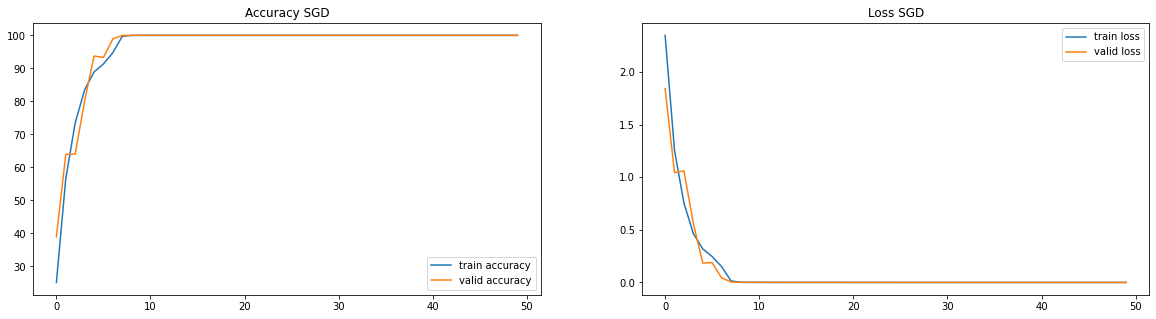

In [26]:
sgd_results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, loss_fn, sgd_opt, sgd_results, opt_name="SGD", model=sgd_model, epochs=50, device=device)

ADAM
-------------------------------
Epoch 1
-------------------------------
loss: 3.215783  [    0/21964]
loss: 2.871789  [ 3200/21964]
loss: 2.284645  [ 6400/21964]
loss: 2.210385  [ 9600/21964]
loss: 1.785244  [12800/21964]
loss: 1.779942  [16000/21964]
loss: 1.629514  [19200/21964]
Train Error: 
 Accuracy: 31.9%, Avg loss: 2.098629 

Validation Error: 
 Accuracy: 50.8%, Avg loss: 1.418318 

Epoch 2
-------------------------------
loss: 1.119837  [    0/21964]
loss: 1.347997  [ 3200/21964]
loss: 1.504817  [ 6400/21964]
loss: 1.113140  [ 9600/21964]
loss: 1.612597  [12800/21964]
loss: 0.934781  [16000/21964]
loss: 1.215433  [19200/21964]
Train Error: 
 Accuracy: 59.6%, Avg loss: 1.165561 

Validation Error: 
 Accuracy: 69.7%, Avg loss: 0.852017 

Epoch 3
-------------------------------
loss: 0.855989  [    0/21964]
loss: 0.813483  [ 3200/21964]
loss: 0.885342  [ 6400/21964]
loss: 0.713633  [ 9600/21964]
loss: 0.617730  [12800/21964]
loss: 0.576033  [16000/21964]
loss: 0.826352  [1920

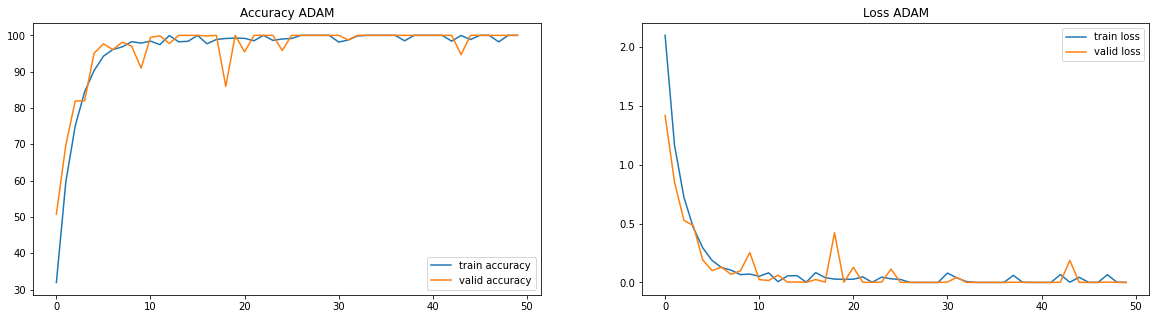

In [27]:
adam_results =  {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, loss_fn, adam_opt, adam_results, opt_name="ADAM", model=adam_model, epochs=50, device=device)

# Test ...

In [28]:
def test_loop(dataloader, model, loss_fn, opt_name, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f'Test results for {opt_name}')
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Test loss: {test_loss:>8f} \n")

In [29]:
test_loop(test_loader, sgd_model, loss_fn, opt_name="SGD", device=device)
test_loop(test_loader, adam_model, loss_fn, opt_name="Adam", device=device)

Test results for SGD
Test Error: 
 Accuracy: 80.8%, Test loss: 1.404292 

Test results for Adam
Test Error: 
 Accuracy: 81.1%, Test loss: 1.196400 



# Add Dropout to our model

In [30]:
## Some Hyperparameters
inp_siz=784
hiden_siz=512
num_clases=25
p = 0.5

## We define our model with Dropout

sgd_model_drop = torch.nn.Sequential()
sgd_model_drop.add_module("dense1", torch.nn.Linear(inp_siz, hiden_siz))
sgd_model_drop.add_module("relu1", torch.nn.ReLU())
#sgd_model_drop.add_module("dropout1", torch.nn.Dropout(p=p))
sgd_model_drop.add_module("dense2", torch.nn.Linear(hiden_siz, 2*hiden_siz))
sgd_model_drop.add_module("relu2", torch.nn.ReLU())
sgd_model_drop.add_module("dropout2", torch.nn.Dropout(p=p))
sgd_model_drop.add_module("dense3", torch.nn.Linear(2*hiden_siz, hiden_siz))
sgd_model_drop.add_module("relu3", torch.nn.ReLU())
#sgd_model_drop.add_module("dropout3", torch.nn.Dropout(p=p))
sgd_model_drop.add_module("dense4", torch.nn.Linear(hiden_siz, num_clases))


sgd_learning_rate = 1e-2
sgd_opt = torch.optim.SGD(sgd_model_drop.parameters(), lr=sgd_learning_rate, momentum=0.9)

In [31]:
sgd_model_drop

Sequential(
  (dense1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (dense2): Linear(in_features=512, out_features=1024, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=1024, out_features=512, bias=True)
  (relu3): ReLU()
  (dense4): Linear(in_features=512, out_features=25, bias=True)
)

SGD+Dropout
-------------------------------
Epoch 1
-------------------------------
loss: 3.218593  [    0/21964]
loss: 3.130156  [ 3200/21964]
loss: 3.110183  [ 6400/21964]
loss: 2.425321  [ 9600/21964]
loss: 2.160566  [12800/21964]
loss: 1.936519  [16000/21964]
loss: 1.878055  [19200/21964]
Train Error: 
 Accuracy: 20.3%, Avg loss: 2.514986 

Validation Error: 
 Accuracy: 32.8%, Avg loss: 1.913270 

Epoch 2
-------------------------------
loss: 1.911312  [    0/21964]
loss: 2.126105  [ 3200/21964]
loss: 1.891965  [ 6400/21964]
loss: 1.580908  [ 9600/21964]
loss: 1.120597  [12800/21964]
loss: 1.227134  [16000/21964]
loss: 1.485527  [19200/21964]
Train Error: 
 Accuracy: 47.7%, Avg loss: 1.511308 

Validation Error: 
 Accuracy: 59.5%, Avg loss: 1.180512 

Epoch 3
-------------------------------
loss: 1.264073  [    0/21964]
loss: 1.334566  [ 3200/21964]
loss: 1.361891  [ 6400/21964]
loss: 1.059414  [ 9600/21964]
loss: 0.998179  [12800/21964]
loss: 0.844421  [16000/21964]
loss: 1.037224

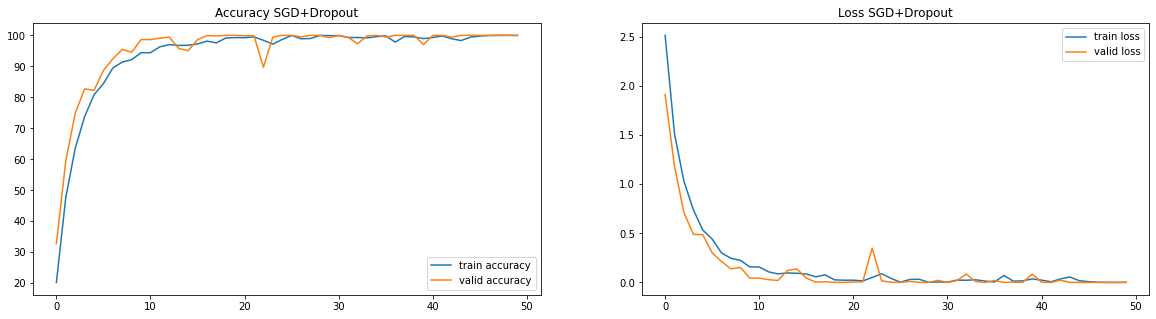

In [32]:
sgd_results_drop = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, loss_fn, sgd_opt, sgd_results_drop, opt_name="SGD+Dropout", model=sgd_model_drop, epochs=50, device=device)

ADAM+Dropout
-------------------------------
Epoch 1
-------------------------------
loss: 3.211813  [    0/21964]
loss: 3.005767  [ 3200/21964]
loss: 2.105396  [ 6400/21964]
loss: 2.259304  [ 9600/21964]
loss: 2.017702  [12800/21964]
loss: 1.808534  [16000/21964]
loss: 1.489350  [19200/21964]
Train Error: 
 Accuracy: 31.1%, Avg loss: 2.140908 

Validation Error: 
 Accuracy: 47.0%, Avg loss: 1.479971 

Epoch 2
-------------------------------
loss: 1.769199  [    0/21964]
loss: 1.133756  [ 3200/21964]
loss: 1.422323  [ 6400/21964]
loss: 1.586179  [ 9600/21964]
loss: 1.512439  [12800/21964]
loss: 1.199895  [16000/21964]
loss: 1.146604  [19200/21964]
Train Error: 
 Accuracy: 58.7%, Avg loss: 1.186802 

Validation Error: 
 Accuracy: 71.4%, Avg loss: 0.833838 

Epoch 3
-------------------------------
loss: 0.767582  [    0/21964]
loss: 0.776037  [ 3200/21964]
loss: 0.803017  [ 6400/21964]
loss: 0.548782  [ 9600/21964]
loss: 0.668328  [12800/21964]
loss: 0.973830  [16000/21964]
loss: 0.84122

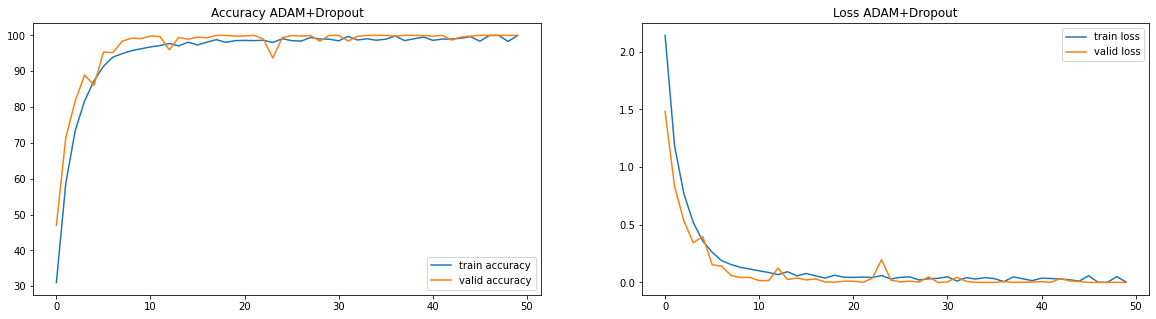

In [33]:
## Some Hyperparameters
inp_siz=784
hiden_siz=512
num_clases=25
p = 0.5

## We define model with Dropout

adam_model_drop = torch.nn.Sequential()
adam_model_drop.add_module("dense1", torch.nn.Linear(inp_siz, hiden_siz))
adam_model_drop.add_module("relu1", torch.nn.ReLU())
#adam_model_drop.add_module("dropout1", torch.nn.Dropout(p=p))
adam_model_drop.add_module("dense2", torch.nn.Linear(hiden_siz, 2*hiden_siz))
adam_model_drop.add_module("relu2", torch.nn.ReLU())
adam_model_drop.add_module("dropout2", torch.nn.Dropout(p=p))
adam_model_drop.add_module("dense3", torch.nn.Linear(2*hiden_siz, hiden_siz))
adam_model_drop.add_module("relu3", torch.nn.ReLU())
#adam_model_drop.add_module("dropout3", torch.nn.Dropout(p=p))
adam_model_drop.add_module("dense4", torch.nn.Linear(hiden_siz, num_clases))

adam_learning_rate = 3e-4
adam_opt = torch.optim.Adam(adam_model_drop.parameters(), lr=adam_learning_rate)

adam_results_drop =  {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, loss_fn, adam_opt, adam_results_drop, opt_name="ADAM+Dropout", model=adam_model_drop, epochs=50, device=device)

In [34]:
test_loop(test_loader, sgd_model_drop, loss_fn, opt_name="SGD+Dropout", device=device)
test_loop(test_loader, adam_model_drop, loss_fn, opt_name="ADAM+Dropout", device=device)

Test results for SGD+Dropout
Test Error: 
 Accuracy: 85.4%, Test loss: 1.116887 

Test results for ADAM+Dropout
Test Error: 
 Accuracy: 83.1%, Test loss: 0.997822 



همانطور که مشخص است با اضافه کردن دراپ اوت؛ دقت تست ما حدود 4 الی 5 درصد بهبود پیدا کرد و این به دلیل خاصیت رگولارایز بودن دراپ اوت است .

## Best Model = SGD + Dropout

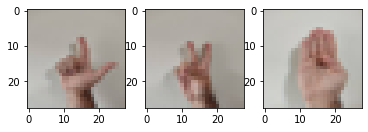

In [56]:
from PIL import Image
im1 = Image.open("IMG1.jpg").resize((28,28))
im2 = Image.open("IMG2.jpg").resize((28,28))
im3 = Image.open("IMG3.jpg").resize((28,28))
idx = 0
for pic in [im1, im2, im3]:
    plt.subplot(int(f'13{idx+1}'))
    plt.imshow(pic)
    idx += 1
plt.show()

In [57]:
im1 = Image.open("IMG1.jpg").resize((28,28)).convert("L")
im2 = Image.open("IMG2.jpg").resize((28,28)).convert("L")
im3 = Image.open("IMG3.jpg").resize((28,28)).convert("L")

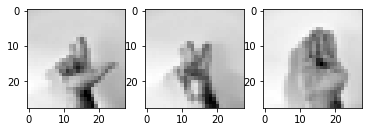

In [58]:
idx = 0
for pic in [im1, im2, im3]:
    plt.subplot(int(f'13{idx+1}'))
    plt.imshow(pic, cmap='gray')
    idx += 1
plt.show()

In [59]:
im1_arr = np.array(im1)
im2_arr = np.array(im2)
im3_arr = np.array(im3)
print(im1_arr.shape, im2_arr.shape, im3_arr.shape)

(28, 28) (28, 28) (28, 28)


In [60]:
im1_arr = im1_arr.reshape((1, 28*28))
im2_arr = im2_arr.reshape((1, 28*28))
im3_arr = im3_arr.reshape((1, 28*28))
print(im1_arr.shape, im2_arr.shape, im3_arr.shape)

(1, 784) (1, 784) (1, 784)


In [61]:
im1_arr = torch.tensor(im1_arr / 255.,  dtype=torch.float32).to(device)
im2_arr = torch.tensor(im2_arr / 255.,  dtype=torch.float32).to(device)
im3_arr = torch.tensor(im3_arr / 255.,  dtype=torch.float32).to(device)
print(im1_arr.shape, im2_arr.shape, im3_arr.shape)

torch.Size([1, 784]) torch.Size([1, 784]) torch.Size([1, 784])


In [62]:
pred1 = alphabet[sgd_model_drop(im1_arr).argmax(1)]
pred2 = alphabet[sgd_model_drop(im2_arr).argmax(1)]
pred3 = alphabet[sgd_model_drop(im3_arr).argmax(1)]

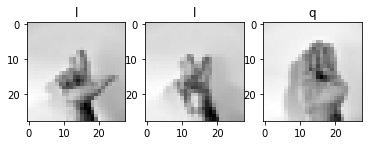

In [63]:
idx = 0
for pic, label in [(im1,pred1), (im2,pred2) , (im3,pred3)]:
    plt.subplot(int(f'13{idx+1}'))
    plt.imshow(pic, cmap='gray')
    plt.title(label)
    idx += 1
plt.show()